### Overview about the project:
In this project, I will overview the dataset '525-bird-species.' I will explore the data, transform it into a format for modeling, and then create classification models to predict the species of birds given a picture of a bird. In this dataset, one bird species was incorrect and therefore removed, which resulted in 524 bird species in total.

### About The Data:

Data set of 524 bird species. 84479 training images, 2620 test images and 2620 validation images
All images are 224 X 224 X 3 color images in jpg format. Data set includes a train set, test set and validation set. Each set contains 524 sub directories, one for each bird species

### Summary Of Methods:

For each model, I used the imagedatagenerator in keras. I created each model as described below. Each model is compiled using a batchsize/samples ratio for the epochs_per_step (on training and validation steps). The compiled models are fit to the generator data for epochs required with patience of 5. I graphed the validation and training data loss and accuracy as a function of epochs. Finally, the third dataset - test - was compared to the model to give a true accuracy and loss value for each fit model.

### Analysis of Results:
Best accuracy achived by MobileNet(95.3% accuracy)

In [1]:
#Import packages used here:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)


2.15.0


In [2]:
# setup my directories
train_directory = 'input/train'
test_directory = 'input/test'
val_directory = 'input/valid'

In [3]:
categories = os.listdir(train_directory) # list the names of the categories that in my data
print(str(len(categories)),'CATEGORIES are ', categories)

category_count = len(categories)
# we will use "category_count" as the number of classes that we need to classify instead of typing 525 because the data is continuously increasing

# Create the labels.json file
json_data = {str(i): bird for i, bird in enumerate(categories)}
with open('labels.json', 'w') as json_file:
    json.dump(json_data, json_file, indent=4)
# End of create labels.json file.

525 CATEGORIES are  ['CARMINE BEE-EATER', 'IVORY BILLED ARACARI', 'FRIGATE', 'COPPERSMITH BARBET', 'GOLDEN CHEEKED WARBLER', 'GREAT TINAMOU', 'NORTHERN SHOVELER', 'ASIAN OPENBILL STORK', 'EMERALD TANAGER', 'AMERICAN GOLDFINCH', 'BARROWS GOLDENEYE', 'ELEGANT TROGON', 'DUSKY LORY', 'CHUKAR PARTRIDGE', 'COMMON POORWILL', 'BLONDE CRESTED WOODPECKER', 'AZARAS SPINETAIL', 'OSTRICH', 'MALAGASY WHITE EYE', 'BORNEAN PHEASANT', 'FAIRY BLUEBIRD', 'COLLARED ARACARI', 'GREATER PRAIRIE CHICKEN', 'GILDED FLICKER', 'DOWNY WOODPECKER', 'ALEXANDRINE PARAKEET', 'NORTHERN BEARDLESS TYRANNULET', 'AMETHYST WOODSTAR', 'LARK BUNTING', 'CUBAN TODY', 'DEMOISELLE CRANE', 'GOULDIAN FINCH', 'WATTLED CURASSOW', 'ANNAS HUMMINGBIRD', 'PURPLE SWAMPHEN', 'HELMET VANGA', 'COCKATOO', 'COCK OF THE  ROCK', 'GOLDEN PARAKEET', 'IVORY GULL', 'ROCK DOVE', 'VENEZUELIAN TROUPIAL', 'HARLEQUIN QUAIL', 'NORTHERN FULMAR', 'SCARLET FACED LIOCICHLA', 'RED TAILED THRUSH', 'STRIATED CARACARA', 'ORANGE BREASTED TROGON', 'CAPE MAY WARBLER

In [3]:
augmented_gen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest') 

general_datagen = ImageDataGenerator(rescale = 1./255) # for training, validation and testing data

train_generator = general_datagen.flow_from_directory(
    train_directory,
    target_size = (224, 224),
    batch_size = 32
)
valid_generator = general_datagen.flow_from_directory(
    val_directory,
    target_size = (224, 224),
    batch_size = 32
)
test_generator = general_datagen.flow_from_directory(
    test_directory,
    target_size = (224, 224),
    batch_size = 32,
    shuffle = False
)

NameError: name 'train_directory' is not defined

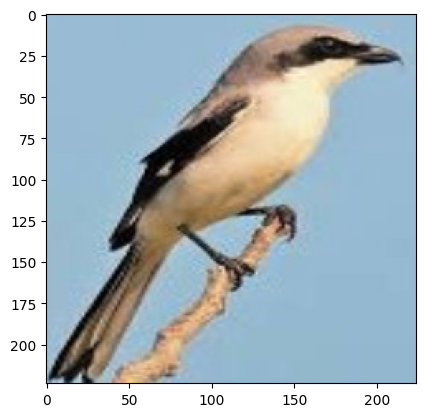

In [5]:
# ploting a sample from my data
def plot_image(generator):
    images_in_batch = next(generator) # images_in_batch will output (batch_size, height, width, n_channels)
    img = images_in_batch[0][0] # img will output (height, width, n_chennels)
    
    plt.imshow(img)

plot_image(train_generator)

In [6]:
# i will be using it to determine steps_per_epoch in my models.
train_groups = len(train_generator) 
valid_groups = len(valid_generator) # validation_step

print(f"Train groups: {train_groups}")
print(f"Validation groups: {valid_groups}")

Train groups: 2640
Validation groups: 82


### MobileNet

In [7]:
# this dense layer i will not only use it for my base model i will use it in the pretrained model too
def dense_layer(inputs, out, dropout_rate = 0.5):
    x = layers.Dense(out)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    
    return x

In [8]:
keras.backend.clear_session()

base_mobilenet = keras.applications.MobileNet(
    weights = 'imagenet',
    include_top = False, 
    input_shape = (224, 224, 3)
)
base_mobilenet.trainable = False

inputs = keras.Input(shape = (224, 224, 3))

x = base_mobilenet(inputs)

x = layers.Flatten()(x)

x = dense_layer(x, 512)

outputs = layers.Dense(category_count, activation = "softmax")(x)
mobilenet_model = keras.Model(inputs, outputs)

2023-12-10 11:56:33.536840: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
mobilenet_model.compile(optimizer = tf.keras.optimizers.Adam(lr=0.001),
                        loss = "categorical_crossentropy",
                        metrics = ["accuracy"]
)
callbacks=[
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True),
    
    keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7, patience = 2, verbose = 1),
    
    keras.callbacks.ModelCheckpoint( filepath = "mobilenet_model.keras",save_best_only = True,monitor = "val_loss")
]
history = mobilenet_model.fit( 
    train_generator, 
    steps_per_epoch = train_groups, 
    epochs = 20, # adding more epochs will increase the acc like 1% or 2%
    validation_data = valid_generator,
    validation_steps = valid_groups,
    verbose = 1,
    callbacks=callbacks
)

Epoch 1/20
2640/2640 [==============================] - 749s 280ms/step - loss: 1.8947 - accuracy: 0.5789 - val_loss: 0.4333 - val_accuracy: 0.8840 - lr: 0.0010
Epoch 2/20
2640/2640 [==============================] - 723s 274ms/step - loss: 0.6176 - accuracy: 0.8330 - val_loss: 0.3687 - val_accuracy: 0.9008 - lr: 0.0010
Epoch 3/20
2640/2640 [==============================] - 724s 274ms/step - loss: 0.3722 - accuracy: 0.8905 - val_loss: 0.3385 - val_accuracy: 0.9076 - lr: 0.0010
Epoch 4/20
2640/2640 [==============================] - 720s 273ms/step - loss: 0.2662 - accuracy: 0.9192 - val_loss: 0.3262 - val_accuracy: 0.9065 - lr: 0.0010
Epoch 5/20
2640/2640 [==============================] - 714s 271ms/step - loss: 0.2158 - accuracy: 0.9347 - val_loss: 0.3305 - val_accuracy: 0.9149 - lr: 0.0010
Epoch 6/20
2640/2640 [==============================] - ETA: 0s - loss: 0.1816 - accuracy: 0.9438
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
2640/2640 [==========

In [1]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label = "Trianing accuracy")
plt.plot(epochs, val_accuracy, "b-", label = "Validation accuracy")
plt.title("Accuracy on training and validation data")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label = "Trianing loss")
plt.plot(epochs, val_loss, "b-", label = "Validation loss")
plt.title("loss on training and validation data")
plt.title("loss on training and validation data")
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [11]:
test_model_mobile = keras.models.load_model("mobilenet_model.keras")
_, test_acc = test_model_mobile.evaluate(test_generator)
print(f"The accuracy of the mobilenet model on the test set is : {test_acc:.3f}")

82/82 [==============================] - 18s 177ms/step - loss: 0.1979 - accuracy: 0.9454
The accuracy of the mobilenet model on the test set is : 0.945


# Making tests to model

In [12]:
testr_directory = 'input/test'

In [13]:
testr_generator = general_datagen.flow_from_directory(
    testr_directory,
    target_size = (224, 224),
    batch_size = 1
)

categories = os.listdir(testr_directory) # list the names of the categories that in my data
#print(str(len(categories)),'CATEGORIES are ', categories)

Found 2621 images belonging to 525 classes.


In [14]:
test_model_mobile = keras.models.load_model("mobilenet_model.keras")
_, test_acc = test_model_mobile.evaluate(testr_generator)
print(f"The accuracy of the mobilenet model on the test set is : {test_acc:.3f}")

2621/2621 [==============================] - 90s 34ms/step - loss: 0.1979 - accuracy: 0.9454
The accuracy of the mobilenet model on the test set is : 0.945


## A test for predicting one bird at a time



In [15]:
from keras.models import load_model

1/1 [==============================] - 1s 874ms/step
Class: CRESTED COUA, Probability: 99% 
Class: CRAB PLOVER, Probability: 0% 
Class: POMARINE JAEGER, Probability: 0% 



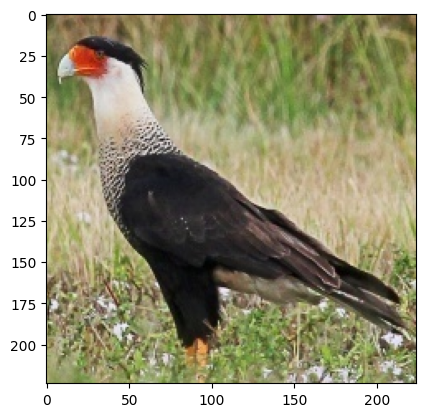

In [16]:
# Load the MobileNet model from the file
mobilenet_model = load_model('mobilenet_model.keras')

plot_image(testr_generator)

test_image = testr_generator[0][0]

# Get predicton from model
prediction = mobilenet_model.predict(test_image)

# Get the predicted class probabilities for all classes
predicted_probabilities = prediction[0]

# Get the predicted class probability
predicted_class_probability = np.argsort(predicted_probabilities)[::-1]

# Select the top three classes with the highest probabilities
top_three_indices = predicted_class_probability[:3]

# Load the class indices from the "translation_order_of_birds.txt" file
with open('translation_order_of_birds.txt', 'r') as f:
    class_indices_to_labels_json = f.read()
    class_indices_to_labels = json.loads(class_indices_to_labels_json)

# Get the class labels for the top three classes
top_three_labels = [class_indices_to_labels.get(str(i)) for i in top_three_indices]

# Get the corresponding probabilities
top_three_probabilities = [predicted_probabilities[i] for i in top_three_indices]

# Print the predicted label
print(f"Class: {top_three_labels[0]}, Probability: {int(top_three_probabilities[0] * 100)}% \n" 
     + f"Class: {top_three_labels[1]}, Probability: {int(top_three_probabilities[1] * 100)}% \n"
    + f"Class: {top_three_labels[2]}, Probability: {int(top_three_probabilities[2] * 100)}% \n")